In [1]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adagrad
from keras.optimizers import Adam
import numpy as np
from PIL import Image
import os
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense

# 学習用のデータを作る.
image_list = []
label_list = []

# ./data/train 以下のorange,appleディレクトリ以下の画像を読み込む。
for dir in os.listdir("data/train"):
    if dir == ".DS_Store":
        continue

    dir1 = "data/train/" + dir 
    label = 0

    if dir == "A":    # doraはラベル0
        label = 0
    elif dir == "B": # pikaはラベル1
        label = 1

    elif dir == "C": # shinはラベル2
        label = 2


    elif dir == "D": # pikaはラベル1
        label = 3

    elif dir == "E": # shinはラベル2
        label = 4
        
    elif dir == "F": # shinはラベル2
        label = 5


    elif dir == "G": # pikaはラベル1
        label = 6

    elif dir == "H": # shinはラベル2
        label = 7
        
    elif dir == "I": # pikaはラベル1
        label = 8

    elif dir == "J": # shinはラベル2
        label = 9


    elif dir == "K": # pikaはラベル1
        label = 10


    elif dir == "L": # shinはラベル2
        label = 11
        
    elif dir == "M": # shinはラベル2
        label = 12


    elif dir == "N": # pikaはラベル1
        label = 13

    elif dir == "O": # shinはラベル2
        label = 14        
    
    elif dir == "P": # pikaはラベル1
        label = 15

    elif dir == "Q": # shinはラベル2
        label = 16


    elif dir == "R": # pikaはラベル1
        label = 17

    elif dir == "S": # shinはラベル2
        label = 18
        
    elif dir == "T": # shinはラベル2
        label = 19


    elif dir == "U": # pikaはラベル1
        label = 20

    elif dir == "V": # shinはラベル2
        label = 21       
        
    elif dir == "W": # shinはラベル2
        label = 22
        
    elif dir == "X": # shinはラベル2
        label = 23


    elif dir == "Y": # pikaはラベル1
        label = 24

    elif dir == "Z": # shinはラベル2
        label = 25       
        
                
        
                
        
        
    for file in os.listdir(dir1):
        if file != ".DS_Store":
            # 配列label_listに正解ラベルを追加(どら:0 ぴか:1しん2)
            label_list.append(label)
            filepath = dir1 + "/" + file
            # 画像を28x28pixelに変換し、1要素が[R,G,B]3要素を含む配列の28x28の２次元配列として読み込む。
            # [R,G,B]はそれぞれが0-255の配列。
            image = np.array(Image.open(filepath).resize((28, 28)))
            image.shape
        
        
            # 出来上がった配列をimage_listに追加。
            image_list.append(image / 255.)

# kerasに渡すためにnumpy配列に変換。
image_list = np.array(image_list)

# ラベルの配列を1と0からなるラベル配列に変更
# 0 -> [1,0], 1 -> [0,1] という感じ。
Y = to_categorical(label_list)

Using TensorFlow backend.


In [2]:
from keras.models import model_from_json
model = model_from_json(open('lenet_AE.json').read())

In [3]:
# オプティマイザにAdamを使用
opt = Adam(lr=0.001)
# モデルをコンパイル
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model.load_weights('lenet_AE_weights.h5')

In [4]:
class_names = np.array(["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z",])

J: 100.00%
Z: 0.00%
Y: 0.00%



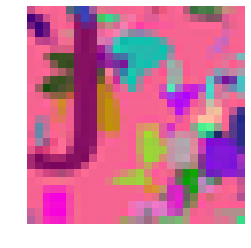

In [58]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def predict_single_img(img):
    x = np.expand_dims(img, axis=0)  # バッチの次元を追加する。

    # 推論する。
    scores = model.predict(x)[0]
    top3_classes = scores.argsort()[-3:][::-1]

    # 推論結果を表示する。
    for name, score in zip(class_names[top3_classes], scores[top3_classes]):
        print('{}: {:.2%}'.format(name, score))
    print()

img = cv2.imread('data/test/J/J0.png')  # 画像を読み込む。
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_CUBIC) # リサイズする。

# 推論する。
predict_single_img(img)

# 画像を描画する。
plt.axis('off')
plt.imshow(img)
plt.show()

In [59]:
sess = tf.keras.backend.get_session()

# Adversarial Examples 用のモデルを作成する。
target_class_input = tf.placeholder(dtype=tf.int32)
logits = sess.graph.get_tensor_by_name('dense_2/BiasAdd:0')  # Softmax の直前

loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits=logits, labels=[target_class_input])

gradient = tf.gradients(loss, model.input)

In [60]:
def find_adversary_noise(img, target_class,
                         noise_limit=50., required_score=0.99, max_iterations=100):
    noise = 0  # ノイズの初期値は0にする。

    # 画像の予測ラベル
    x = np.expand_dims(img, axis=0)
    src_class = model.predict(x).argmax()

    for i in range(max_iterations):
        # 画像にノイズを加える。
        noisy_img = img + noise

        # 画素値を [0, 255] に収まるようにクリップする。
        noisy_img = np.clip(noisy_img, a_min=0, a_max=255)

        # 予測値及び勾配を計算する。
        x = np.expand_dims(noisy_img, axis=0)
        pred, grad = sess.run([model.output, gradient],
                               feed_dict={model.input: x, target_class_input: target_class})
        pred = np.squeeze(pred)  # (1, NumClasses) -> (NumClasses,)
        grad = np.squeeze(grad)  # (1, 1, Height, Width, 3) -> (Height, Width, 3)

        # ステップ数を計算する。
        grad_absmax = np.abs(grad).max()
        if grad_absmax < 1e-10:
            grad_absmax = 1e-10
        step_size = 7 / grad_absmax

        src_score = pred[src_class]  # 元の予測ラベルの確率
        target_score = pred[target_class]  # ターゲットのラベルの確率

        # 情報を表示する。
        print('[source] {} {:.2%} [target] {} {:.2%}'.format(
            class_names[src_class], src_score, class_names[target_class], target_score))
        print('[Gradient] min: {:.4f}, max: {:.4f}, stepsize: {:.4f}\n'.format(
            grad.min(), grad.max(), step_size))

        if target_score >= required_score:
            break

        # ノイズを更新する。
        noise -= step_size * grad
        # ノイズを [-noise_limit, noise_limit] に収まるようにクリップする。
        noise = np.clip(a=noise, a_min=-noise_limit, a_max=noise_limit)

    return noise

[source] J 0.00% [target] V 0.00%
[Gradient] min: -0.0264, max: 0.0322, stepsize: 217.2920

[source] J 0.00% [target] V 0.00%
[Gradient] min: -0.0245, max: 0.0346, stepsize: 202.3281

[source] J 0.00% [target] V 0.00%
[Gradient] min: -0.0304, max: 0.0283, stepsize: 230.2594

[source] J 0.00% [target] V 0.00%
[Gradient] min: -0.0243, max: 0.0281, stepsize: 249.0791

[source] J 0.00% [target] V 0.00%
[Gradient] min: -0.0242, max: 0.0241, stepsize: 289.4089

[source] J 0.00% [target] V 0.00%
[Gradient] min: -0.0276, max: 0.0237, stepsize: 253.3815

[source] J 0.00% [target] V 99.99%
[Gradient] min: -0.0000, max: 0.0000, stepsize: 2380121.7925

noise min: -32.7816, max: 26.8221, mean: -0.3257, std: 8.1016
J: 100.00%
Z: 0.00%
Y: 0.00%

J: 100.00%
Z: 0.00%
Y: 0.00%



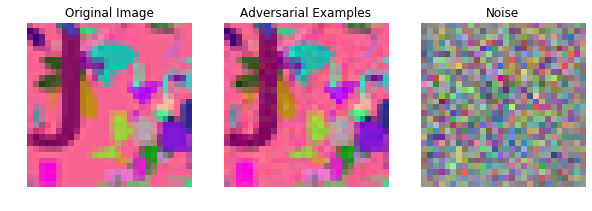

In [62]:
target_class = 21
sess.run(tf.global_variables_initializer())
noise = find_adversary_noise(img, target_class)

print('noise min: {:.4f}, max: {:.4f}, mean: {:.4f}, std: {:.4f}'.format(
    noise.min(), noise.max(), noise.mean(), noise.std()))

# ノイズを付加した画像を生成する。
noisy_img = np.clip(img + noise, a_min=0, a_max=255).astype(np.uint8)

predict_single_img(img)
predict_single_img(noisy_img)

def array_to_img(x):
    '''[0, 1] に正規化
    '''
    return (x - x.min()) / (x.max() - x.min())

cv2.imwrite("ado/JtoV.jpg",noisy_img)
# 描画する。
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title('Original Image')
ax1.imshow(img)
ax1.set_axis_off()

ax2.set_title('Adversarial Examples')
ax2.imshow(noisy_img)
ax2.set_axis_off()

ax3.set_title('Noise')
ax3.imshow(array_to_img(noise))
ax3.set_axis_off()

plt.show()

J: 100.00%
Z: 0.00%
Y: 0.00%



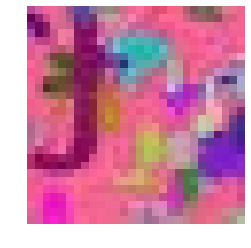

In [63]:
img = cv2.imread('ado/JtoV.jpg')  # 画像を読み込む。
img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_CUBIC) # リサイズする。

# 推論する。
predict_single_img(img)

# 画像を描画する。
plt.axis('off')
plt.imshow(img)
plt.show()